# APPM 4720 Applied Deep Learning
## Progress Report 07 - YOLO Object Detector
## Sabrina Liu, December 1, 2021

The primary objectives of this progress report include: 
* implement the YOLO object detection algorithm as describded in ***You Only Look Once: Unified, Real-Time Object Detection*** by Joseph Redmon, et. al. https://arxiv.org/abs/1506.02640
* explore and understand the PASCAL VOC dataset used for object detection task
* visualize and calculate the bounding boxes and the metrics used for object detection
* implement transfer learning of pre-trained feature extractor weights within custom training loops

I did not find a convenient tutorial on this algorithm so I attempted to build it from scratch which still has some performance issues but conveys the concepts used step by step. 

--- 
## Background

YOLO algorithm is an important milestone for object detection using CNNs. Prior works usually required either multi-stage or multi-task training of neural networks, which often involves making inference on classification or sentiment segmentation tasks first prior to localization. YOLO treats the classification and localization tasks during object detection as a **single regression problem**, predicting bounding boxes and class probabilities at the same time simply using squared-error as loss. The construction of the training targets will be explained later. 

Instead of using a sliding window or making many proposals on multi-level image pyramids, which can be computationally expensive, YOLO partitions the image into equal cells and predicts only a small number of anchor boxes (i.e., 2) centered within each cell. This makes it very efficient especially at **inference time**, which only requires one forward pass, without repeatedly evaluating proposals. The partition method does require some special handling of the bounding box coordinates, which will also be explained and demonstrated. 

---
## The PASCAL VOC Dataset
For this project we will use the PASCAL Visual Object Classes Challenge dataset which can be directly downloaded from tensorflow. A total of 9963 images are included in this dataset, where each image contains a set of objects, out of 20 different classes, making a total of 24640 annotated objects. The format information about class labels and bounding boxes can be located from the dataset metadata. 

http://host.robots.ox.ac.uk/pascal/VOC/

https://www.tensorflow.org/datasets/catalog/voc

#### Import General Dependencies

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image as Display

#### Import PASCAL VOC Dataset

In [2]:
%%time

import tensorflow_datasets as tfds

(ds_train, ds_test, ds_valid), info = tfds.load( 
    "voc", split=["train", "test", "validation"], with_info=True 
)

Wall time: 1.56 s


In [3]:
info

tfds.core.DatasetInfo(
    name='voc',
    full_name='voc/2007/4.0.0',
    description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge,
    corresponding to the Classification and Detection competitions.
    
    In the Classification competition, the goal is to predict the set of labels
    contained in the image, while in the Detection competition the goal is to
    predict the bounding box and label of each individual object.
    annotations.
    """,
    config_description="""
    This dataset contains the data from the PASCAL Visual Object Classes Challenge
    2007, a.k.a. VOC2007.
    
    A total of 9963 images are included in this dataset, where each image
    contains a set of objects, out of 20 different classes, making a total of
    24640 annotated objects.
    
    """,
    homepage='http://host.robots.ox.ac.uk/pascal/VOC/voc2007/',
    data_path='C:\\Users\\Sabrina\\tensorflow_datasets\\voc\\2007\\4.0.0',
    download_size=868.85 Mi

#### Train-Validation-Test Split

In [4]:
len(ds_train), len(ds_valid), len(ds_test)

(2501, 2510, 4952)

#### Object Detection Ground Truth
Based on the dataset information, the ground truth for object detection task contains bounding box locations and class labels. 

In [5]:
info.features['labels']

Sequence(ClassLabel(shape=(), dtype=tf.int64, num_classes=20))

In [6]:
info.features['objects']

Sequence({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'is_difficult': tf.bool,
    'is_truncated': tf.bool,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
    'pose': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
})

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])
tf.Tensor([12 14], shape=(2,), dtype=int64)
{'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.14375   , 0.0437018 , 0.97083336, 0.7763496 ],
       [0.14583333, 0.24164525, 0.57916665, 0.6066838 ],
       [0.6       , 0.5244216 , 0.8541667 , 0.76606685],
       [0.56041664, 0.5012854 , 0.7395833 , 0.6863753 ]], dtype=float32)>, 'is_difficult': <tf.Tensor: shape=(4,), dtype=bool, numpy=array([False, False, False,  True])>, 'is_truncated': <tf.Tensor: shape=(4,), dtype=bool, numpy=array([False, False,  True,  True])>, 'label': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([12, 14, 12, 14], dtype=int64)>, 'pose': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([4, 4, 4, 4], dtype=int64)>}
(480, 389, 3)


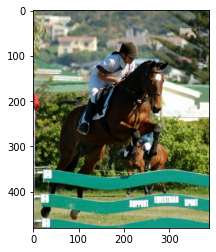

In [7]:
samples = ds_train.take(1)

for sample in samples:
    print(sample.keys())
    print(sample['labels'])
    print(sample['objects'])
    image = sample['image']
    _ = plt.imshow(image)
    print(image.shape)
    break

#### Preview Ground Truth Bounding Boxes
`cvlib` is a tensorflow-based high-level library that can perform object detection directly. Here we just need to borrow its fancy bounding box drawing function which adds the class names (and confidence level when needed) to the bounding boxes. 

https://github.com/arunponnusamy/cvlib/blob/master/cvlib/object_detection.py

In [8]:
# !pip install cvlib
# !pip install opencv-python

In [9]:
from cvlib.object_detection import draw_bbox

help(draw_bbox)

Help on function draw_bbox in module cvlib.object_detection:

draw_bbox(img, bbox, labels, confidence, colors=None, write_conf=False)
    A method to apply a box to the image
    Args:
        img: An image in the form of a numPy array
        bbox: An array of bounding boxes
        labels: An array of labels
        colors: An array of colours the length of the number of targets(80)
        write_conf: An option to write the confidences to the image



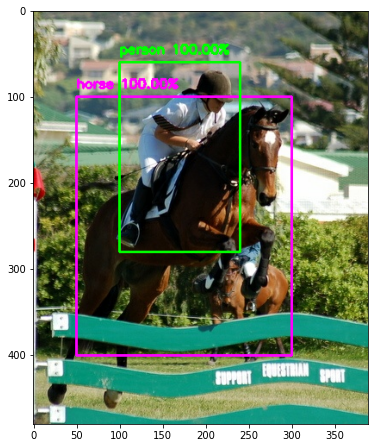

In [10]:
# bbox: [x1, y1, x2, y2]
bbox = [[50, 100, 300, 400], [100, 60, 240, 280]]
conf = [1, 1]
labels = ['horse', 'person']
colors = [(0,255,0),(255,0,255)] * 20

boxed_image = draw_bbox(image.numpy(), bbox, labels, conf, colors, write_conf=True)

plt.figure(figsize=(6, 8))
_ = plt.imshow(boxed_image)

#### Build Custom Bounding Box Drawing Tool

The ground truth bounding boxes are encoded as`[y_min, x_min, y_max, x_max]` as percentages relative to the height and width of image. We need to convert these into the order accepted by the box-drawing function. Also, after a second thought, I copied out the box-drawing function from `cvlib` and modified it to my own need (due to its strict limit on class names). 

In [11]:
def convert_pct_to_pixel(image_shape, bbox_pcts):
    y1 = round(image_shape[0] * bbox_pcts[0])
    x1 = round(image_shape[1] * bbox_pcts[1])
    y2 = round(image_shape[0] * bbox_pcts[2])
    x2 = round(image_shape[1] * bbox_pcts[3])
    return x1, y1, x2, y2

In [12]:
import cv2

def draw_bboxes(img, bboxes, labels, scores=None, colors=None):
    
    if not colors:    # default repeat: green, magenta, yellow, cyan
        colors = [(0, 255, 0), (255, 0, 255), (255, 255, 0), (0, 255, 255)] * 5
    classes = sorted(list(set(labels)))
    
    new_image = img.copy()
    for i, label in enumerate(labels):
        x1, y1, x2, y2 = convert_pct_to_pixel(img.shape[:-1], bboxes[i])
        color = colors[classes.index(label)]
        cv2.rectangle(new_image, (x1, y1), (x2, y2), color, 2)
        if scores:
            label += ' ' + str(format(scores[i] * 100, '.2f')) + '%'
        cv2.putText(new_image, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return new_image

#### Preview Sample Bounding Boxes
Finally, now let's take a few images along with their ground truth, and put the bounding boxes on them. 

In [13]:
N_CLASSES = info.features['labels'].num_classes
N_CLASSES

20

In [14]:
class_names = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 
    'dining table', 'dog', 'horse', 'motorbike', 
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor'
]

len(class_names)

20

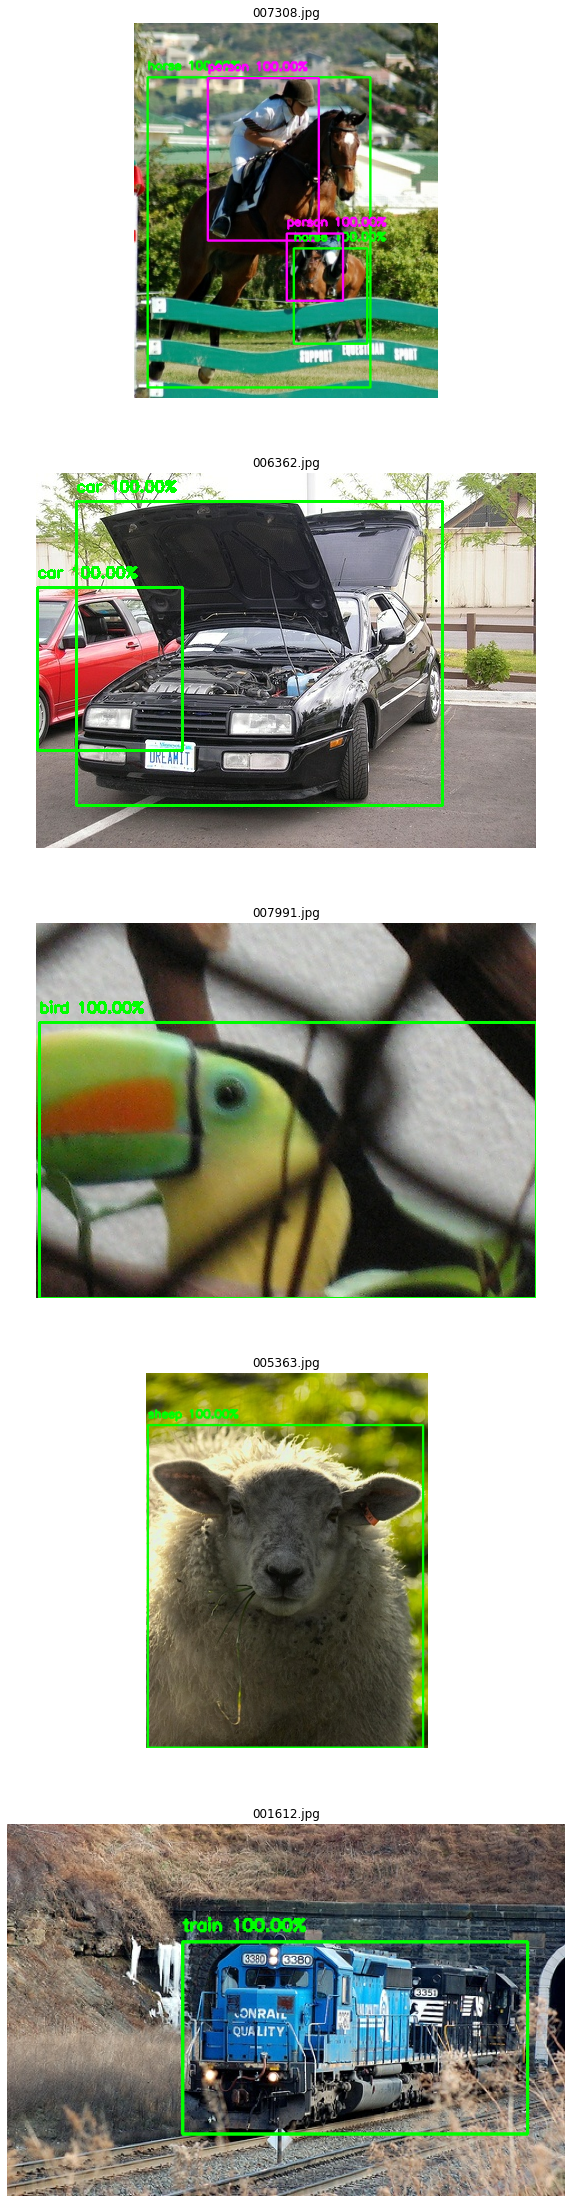

In [15]:
samples = ds_train.take(5)

fig, axes = plt.subplots(5, 1, figsize=(10,40))

c = 0
for sample in samples:
    image = sample['image']
    bboxes = sample['objects']['bbox'].numpy()
    # bboxes = [convert_pct_to_pixel(image.shape[:-1], b) for b in bboxes]
    labels = sample['objects']['label'].numpy()
    labels = [class_names[i] for i in labels]
    conf = [1] * len(bboxes)
    # boxed_image = cvlib.object_detection.draw_bbox(image.numpy(), bboxes, labels, conf, colors)
    boxed_image = draw_bboxes(image.numpy(), bboxes, labels, conf, colors)
    axes[c].imshow(boxed_image)
    axes[c].axis('off')
    axes[c].set(title=sample['image/filename'].numpy().decode())
    c += 1

---
## Prepare Datasets for Training

According to the authors' recommendation, the feature extraction layers of the model is pre-trained on ImageNet for classification (for a week!) which achieved 88% top-5 accuracy before training for object detection. For simplicity, we will pretrain the classification model using the same dataset with `224x224` resolution and refine for object detection with `448x448` resolution. The input data are resized accordingly. 

#### Create Image Classification Batch Dataset

In [16]:
BATCH_SIZE = 64

In [17]:
def generate_classification_inputs(sample):
    """ converts PrefetchDataset to BatchDataset of shape (64, 224, 224, 3)"""
    image = tf.image.convert_image_dtype(sample['image'], dtype=tf.float32)
    image = tf.image.resize(image, size=(224, 224))
    return image


x_cls_train = ds_train.map(generate_classification_inputs).batch(batch_size=BATCH_SIZE)
x_cls_valid = ds_valid.map(generate_classification_inputs).batch(batch_size=BATCH_SIZE)
x_cls_test = ds_test.map(generate_classification_inputs).batch(batch_size=BATCH_SIZE)

(64, 224, 224, 3)
<dtype: 'float32'>


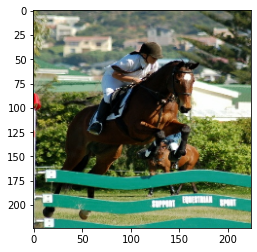

In [18]:
for x in x_cls_train.take(1):
    print(x.shape)
    print(x.dtype)
    _ = plt.imshow(x[0])
    break

#### Create Object Detection Batch Dataset

In [19]:
def generate_detection_inputs(sample):
    """ converts PrefetchDataset to BatchDataset of shape (32, 448, 448, 3)"""
    image = tf.image.convert_image_dtype(sample['image'], dtype=tf.float32)
    image = tf.image.resize(image, size=(448, 448))
    
    return image


x_det_train = ds_train.map(generate_detection_inputs).batch(batch_size=BATCH_SIZE)
x_det_valid = ds_valid.map(generate_detection_inputs).batch(batch_size=BATCH_SIZE)
x_det_test = ds_test.map(generate_detection_inputs).batch(batch_size=BATCH_SIZE)

(64, 448, 448, 3)
<dtype: 'float32'>


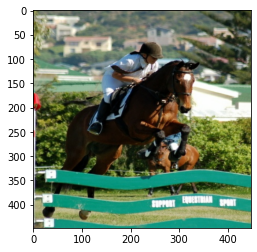

In [20]:
for x in x_det_train.take(1):
    print(x.shape)
    print(x.dtype)
    _ = plt.imshow(x[0])
    break

---
## Training Targets Construction


#### Training Targets for Image Classification

From the dataset `sample['labels']` we can locate the unique image classes (integers) identified as the ground truth for image classification task. Since multiple classes might exist in a particular image, here we only keep one class per image for simplicity. 

In [21]:
samples = ds_train.take(1)

for sample in samples:
    print(sample.keys())
    print(sample['labels'])
    break

dict_keys(['image', 'image/filename', 'labels', 'labels_no_difficult', 'objects'])
tf.Tensor([12 14], shape=(2,), dtype=int64)


In [22]:
def generate_classification_targets(dataset):

    targets = []

    for sample in dataset:
        labels = sample['labels'][0]
        targets.append(labels)
    
    return tf.data.Dataset.from_tensor_slices(
        np.array(targets, dtype='uint8')
    ).batch(BATCH_SIZE)


y_cls_train = generate_classification_targets(ds_train)
y_cls_valid = generate_classification_targets(ds_valid)
y_cls_test = generate_classification_targets(ds_test)

In [23]:
for batch in y_cls_train.take(1):
    print(batch.shape)
    print(batch.dtype)
    print(batch[0])
    break

(64,)
<dtype: 'uint8'>
tf.Tensor(12, shape=(), dtype=uint8)


#### Combine Image Classification Inputs and Targets

In [24]:
x_cls_train

<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [25]:
y_cls_train

<BatchDataset shapes: (None,), types: tf.uint8>

In [26]:
cls_train = tf.data.Dataset.zip((x_cls_train, y_cls_train))
cls_valid = tf.data.Dataset.zip((x_cls_valid, y_cls_valid))
cls_test = tf.data.Dataset.zip((x_cls_test, y_cls_test))

(64, 224, 224, 3) float32
(64,) uint8
12


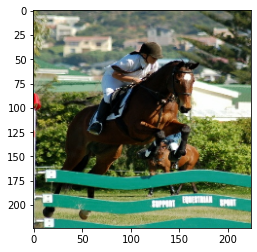

In [27]:
for x, y in cls_train.take(1).as_numpy_iterator():
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    _ = plt.imshow(x[0])
    print(y[0])
    break

#### Training Targets for Object Detection

The YOLO object detection algorithm treats the classification and detection tasks as a single regression problem. This requires the training targets to be transformed into a vector form that contains both class targets and bounding box coordinates. Such target vector is of shape:

$$ S \times S \times (B*5 + C) $$

where $S \times S$ represent the partition cells on the input image, $B$ is the number of bounding box predictions allowed in each window cell, and $C$ is the number of classes present in the dataset. Each bounding box is associated with 5 parameters - c, x, y, w, h, where (x,y) is the center of the box in relative ratio to the **cell** width and height, w and h are square-root width and height of the box in relative ratio to the **image** width and height, and c is confidence of prediction. Below the box coordinates are the class probabilities. So all the targets values are between 0 and 1. 

$$
\underbrace{
    \begin{bmatrix} c^{1,1}_1 \\ x^{1,1}_1 \\ y^{1,1}_1 \\ w^{1,1}_1 \\ h^{1,1}_1 \\ c^{1,1}_2 \\ ... \\ h^{1,1}_B \\ p^{1,1}_1 \\ p^{1,1}_2 \\ ... \\ p^{1,1}_C \end{bmatrix} 
    \quad ... \quad
    \begin{bmatrix} c^{S,S}_1 \\ x^{S,S}_1 \\ y^{S,S}_1 \\ w^{S,S}_1 \\ h^{S,S}_1 \\ c^{S,S}_2 \\ ... \\ h^{S,S}_B \\ p^{S,S}_1 \\ p^{S,S}_2 \\ ... \\ p^{S,S}_C \end{bmatrix}
}_{SxS \text{ vectors}}
$$

Given `S=7`, `B=2`, and `C=20`, the training targets for object detection is of shape `7x7x30`. If there exists a bounding box centered at a certain cell in the ground truth, we put the coordinates, confidence, and class label index in the vector corresponding to that cell and set the confidence to 1. All values are set to 0 if no object exists in a cell.  

#### Identify Box Center in Window Partition

Given `y1, x1, y2, x2` from the ground truth, we can easily derive the relative center position and the relative width as well as the relative height. The next step is to identify the partition cell that the center falls into. This can be done using a quantization method. After that, the center location is normalized to the relative position within the corresponding cell. 

In [28]:
def place_bbox(bbox, S=7, verbose=False):

    y1, x1, y2, x2 = bbox

    bins = np.linspace(0, 1, S + 1)
    # array([0., .14..., .28..., .42..., .57..., .71..., .85..., 1.])

    x = (x1 + x2) / 2      # horizontal center relative to whole image
    y = (y1 + y2) / 2      # vertical center   relative to whole image
    w = np.sqrt(x2 - x1)   # sqrt width        relative to whole image
    h = np.sqrt(y2 - y1)   # sqrt height       relative to whole image
    
    if verbose:
        print("x:", x, "y:", y, "w:", w, "h:", h)

    S1 = np.digitize(x, bins, right=True)
    S2 = np.digitize(y, bins, right=True)
    
    # convert x, y to cell position
    x_min, x_max = bins[S1 - 1], bins[S1]
    x = (x - x_min) / (x_max - x_min)
    y_min, y_max = bins[S2 - 1], bins[S2]
    y = (y - y_min) / (y_max - y_min)

    return S1, S2, x, y, w, h

display(place_bbox([0.14375, 0.0437018,  0.97083336, 0.7763496], verbose=True))
display(place_bbox([0.17065868, 0.86,       0.51197606, 1.        ], verbose=True))

x: 0.4100257 y: 0.55729168 w: 0.8559484797579817 h: 0.9094412350449038


(3,
 4,
 0.8701799000000001,
 0.9010417599999999,
 0.8559484797579817,
 0.9094412350449038)

x: 0.9299999999999999 y: 0.34131736999999995 w: 0.37416573867739417 h: 0.584223741386808


(7,
 3,
 0.5099999999999997,
 0.3892215899999998,
 0.37416573867739417,
 0.584223741386808)

#### Compose Target Tensors

Since we want `SxS` target vectors per image, each existing object within the ground truth is processed using the above center-finding method, converted to a concatenated coordinate vector followed by class one hot vector, then placed within the `SxS` super grid based on the center location. For this exercise, only 2 bounding boxes are allowed for each cell. 

In [29]:
def generate_detection_targets(dataset, S=7, B=2, C=N_CLASSES):

    targets = []

    for sample in dataset:
        labels = sample['objects']['label'].numpy()[:B]
        bboxes = sample['objects']['bbox'].numpy()[:B]

        dummy_grid = np.zeros(shape=(S, S, B * 5 + C))
        count_grid = np.ones(shape=(S, S), dtype=int) * B

        for bbox, label in zip(bboxes, labels):
            s1, s2, x, y, w, h = place_bbox(bbox)
            assert 1 <= s1 <= S, bbox
            assert 1 <= s2 <= S, bbox

            for r in range(S):
                for c in range(S):
                    if (s1 == r+1) & (s2 == c+1):
                        b = count_grid[r-1, c-1]
                        if b >= 0:
                            i = B - b
                            dummy_grid[r, c, i*5:i*5+5] = 1, x, y, w, h
                            dummy_grid[r, c, B*5 +label] = 1
                            count_grid[r, c] -= 1

        targets.append(dummy_grid)
    
    return tf.data.Dataset.from_tensor_slices(
        np.array(targets, dtype='float32')
    ).batch(BATCH_SIZE)


y_det_train = generate_detection_targets(ds_train)
y_det_valid = generate_detection_targets(ds_valid)
y_det_test = generate_detection_targets(ds_test)

In [30]:
for y in y_det_train.take(1):
    print(y.shape)
    print(y.dtype)
    print(y[0, 2, 3, :])
    break

(64, 7, 7, 30)
<dtype: 'float32'>
tf.Tensor(
[1.         0.87018    0.9010418  0.85594845 0.90944123 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.        ], shape=(30,), dtype=float32)


#### Combine Object Detection Inputs and Targets

In [31]:
x_det_train

<BatchDataset shapes: (None, 448, 448, 3), types: tf.float32>

In [32]:
y_det_train

<BatchDataset shapes: (None, 7, 7, 30), types: tf.float32>

In [33]:
det_train = tf.data.Dataset.zip((x_det_train, y_det_train))
det_valid = tf.data.Dataset.zip((x_det_valid, y_det_valid))
det_test = tf.data.Dataset.zip((x_det_test, y_det_test))

(64, 448, 448, 3) float32
(64, 7, 7, 30) float32
[1.         0.87018    0.9010418  0.85594845 0.90944123 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.        ]


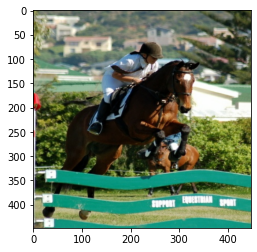

In [34]:
for x, y in det_train.take(1).as_numpy_iterator():
    print(x.shape, x.dtype)
    print(y.shape, y.dtype)
    _ = plt.imshow(x[0])
    print(y[0, 2, 3, :])
    break

---
## Evaluation Metrics

#### Intersection over Union (IoU)

A commonly used evaluation metric for object detection is the intersection over union ratio, or the Jaccard Index, which quantifies the fitness of predicted bounding box coordinates based on its overlapping area against the ground truth. IoU is a metric that works for a single prediction on a single image. Below is a quick demonstration of how the IoU works on single image. 

In [35]:
def display_iou(bbox_true, bbox_pred, iou, img=None):

    if not img:    # use white image as background
        img = np.ones(shape=(448, 448, 3)).astype('uint8') * 255

    bboxes = np.array([bbox_pred, bbox_true])
    labels = ['pred','true']
    colors = [(255,0,255), (0,255,0)]
    
    boxed_image = draw_bboxes(img, bboxes, labels, colors=colors)
    _ = plt.imshow(boxed_image, cmap='gray')
    plt.title(f"IoU = {iou:.2f}")
    pass

In [36]:
def calculate_iou(bbox_true, bbox_pred, display=False):
    
    yp1, xp1, yp2, xp2 = bbox_pred
    yt1, xt1, yt2, xt2 = bbox_true
    
    wp, hp = xp2 - xp1, yp2 - yp1
    wt, ht = xt2 - xt1, yt2 - yt1
    
    area_pred = wp * hp
    area_true = wt * ht

    # get intersection coordinates
    x1 = tf.maximum(xp1, xt1)
    y1 = tf.maximum(yp1, yt1)
    x2 = tf.minimum(xp2, xt2)
    y2 = tf.minimum(yp2, yt2)
    
    w_inter = tf.maximum(0, x2 - x1)
    h_inter = tf.maximum(0, y2 - y1)

    area_inter = w_inter * h_inter
    area_union = area_pred + area_true - area_inter
    iou = area_inter / area_union

    if display:
        _ = display_iou(bbox_pred, bbox_true, iou)

    return iou

<tf.Tensor: shape=(), dtype=float32, numpy=0.26104552>

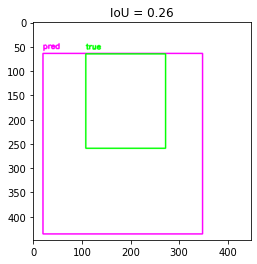

In [37]:
b1 = [0.14375,    0.0437018,  0.97083336, 0.7763496]
b2 = [0.14583333, 0.24164525, 0.57916665, 0.6066838]
b3 = [0.6       , 0.5244216 , 0.8541667 , 0.76606685]
b4 = [0.56041664, 0.5012854 , 0.7395833 , 0.6863753 ]

calculate_iou(b1, b2, display=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

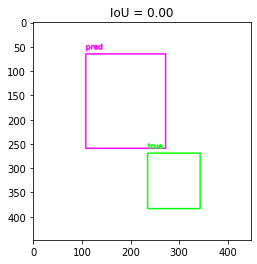

In [38]:
calculate_iou(b2, b3, display=True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.01043582>

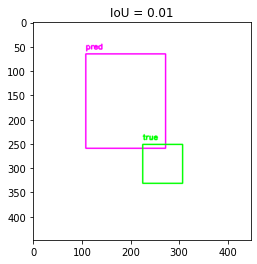

In [39]:
calculate_iou(b2, b4, display=True)

#### Average Precision (Single-Class)

Since there can be many different values of IoUs on either good or bad bounding box predictions, one common practice is to call the prediction a true positive when the IoU is above a certain threshold. Here we use 0.5 as the threshold. Knowing the count of true postiives of all positive predictions allows us to calculate the average precision as a overall metric. 

$$ AP = \frac{|TP|}{|TP|+|FP|} $$ 

In [40]:
score = tf.keras.metrics.Precision()

true = [0, 0, 1, 1]
pred = [1, 0, 1, 1]    # FP, TN, TP, TP

score(true, pred)      # 2 / 3 = 0.667

<tf.Tensor: shape=(), dtype=float32, numpy=0.6666667>

In [41]:
score = tf.keras.metrics.Precision()

true = [[0, 0], [1, 1]]
pred = [[1, 0], [1, 1]]   # (2, 2)

score(true, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6666667>

In [42]:
score = tf.keras.metrics.Precision()

true = tf.ones((64, 7, 7, 2))      # simulates box prediction
pred = tf.ones((64, 7, 7, 2))      # expecting precision = 1

score(true, pred)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [43]:
score = tf.keras.metrics.Precision()

true = [[0,   0,   0,   1,   0],
        [0,   0,   0,   0,   1]]      # 5 classes, label = 3, 4
pred = [[0.0, 0.1, 0.2, 0.1, 0.6],
        [0.0, 0.1, 0.2, 0.1, 0.6]]    # probability vector

print(score(true, pred))              # expecting 0.5

tf.Tensor(0.5, shape=(), dtype=float32)


#### Mean Average Precision (Multi-Class)

When predicting multiple classes at the same time, we would like to know the mean average precison (mAP), which is average precision further averaged along all classes. 

$$ mAP = \frac{1}{C} \sum_{1}^{C} AP_c $$

For simplicity, we will be predicitng only one class per cell and only need to use the Average Precision for metrics. 

 ---
## Objective Function

Ideally, we would like to treat the model as a simple regression problem and use **sum-squared-error** for optimization. However, the authors pointed out that it does not align with the goal of **maximizing average precision**. One solution is to calculate the losses from bounding box locations and classification predictions separately and assign some weights to them. 


#### Multi-Part Loss Function

The proposed **total loss** adds up 4 terms:
1. bounding box coordinate loss - SSE for x, y, w, h, calculated only when object exists in cell, weighted
2. confidence prediction loss - SSE for c, calculated only when object exists in cell
3. confidence regularization loss - SSE for c, calculated only when object **DOES NOT** exist in cell, weighted
4. classification loss - SSE for class predictions, calculated only when object exists in cell

$$ \mathcal{L}_\text{total} = 
\lambda_\text{box} \mathcal{L}_\text{box} 
+ \mathcal{L}_\text{conf} 
+ \lambda_\text{reg}\mathcal{L}_\text{conf} 
+ \mathcal{L}_\text{class}
$$

#### Bounding Box Coordinate Loss

Coordinate loss is only calculated when the object exists in the cell. Since sum-squared-error weights errors equally for large and small boxes, we can use the square roots of width and height to make small changes in bigger boxes less impactful. 

$$ \mathcal{L}_\text{box} = \sum_{i=1}^{S^2} \sum_{j=1}^{B}\left[
(x_i - \hat{x}_i)^2 + (y_i - \hat{y}_i)^2 + (\sqrt{w_i} - \sqrt{\hat{w}_i})^2 + (\sqrt{h_i} - \sqrt{\hat{h}_i})^2
\right] $$

The width and height values are already processed as square roots in training targets so we can directly use them for predictions.

In [44]:
box_true = tf.ones(shape=(7,7,2,4))
box_pred = tf.zeros(shape=(7,7,2,4))

tf.reduce_sum(tf.math.squared_difference(box_true, box_pred))

<tf.Tensor: shape=(), dtype=float32, numpy=392.0>

#### Confidence Loss

Confidence loss is used to predict the confidence score of if an object of a certain class exists centered with the cell. When object does exist, the squared-error loss for confidence loss is calculated as normal. Since many cells do not have an object within an image, this can push the confidence prediction to zero and bias the gradient calculations. Therefore, a regularization term is added to the total loss forcing the confidence values in these cells to update. 

$$ \mathcal{L}_\text{conf} = \sum_{i=1}^{S^2} \sum_{j=1}^{B} (c_i - \hat{c}_i)^2  $$

In [45]:
conf_true = tf.ones(shape=(7,7,2,1))
conf_pred = tf.zeros(shape=(7,7,2,1))

tf.reduce_sum(tf.math.squared_difference(conf_true, conf_pred))

<tf.Tensor: shape=(), dtype=float32, numpy=98.0>

#### Classification Loss

Instead of using cross-entropy loss, the classification loss is also calculated using squared error. The loss is only calculated when object exists within the cell. 

$$ \mathcal{L}_\text{class} = \sum_{i=1}^{S^2} \sum_{k=1}^{C} (p_i - \hat{p}_i)^2  $$

In [46]:
cls_true = tf.ones(shape=(7,7,20))
cls_pred = tf.zeros(shape=(7,7,20))

tf.reduce_sum(tf.math.squared_difference(cls_true, cls_pred))

<tf.Tensor: shape=(), dtype=float32, numpy=980.0>

---
## Feature Extractor

The architecture of the neural network is simple. The authors proposed 20 convolutional layers to be used as feature extractor, which is pretrained on a image classifier and later transfered to the object detector with different exit layers. 

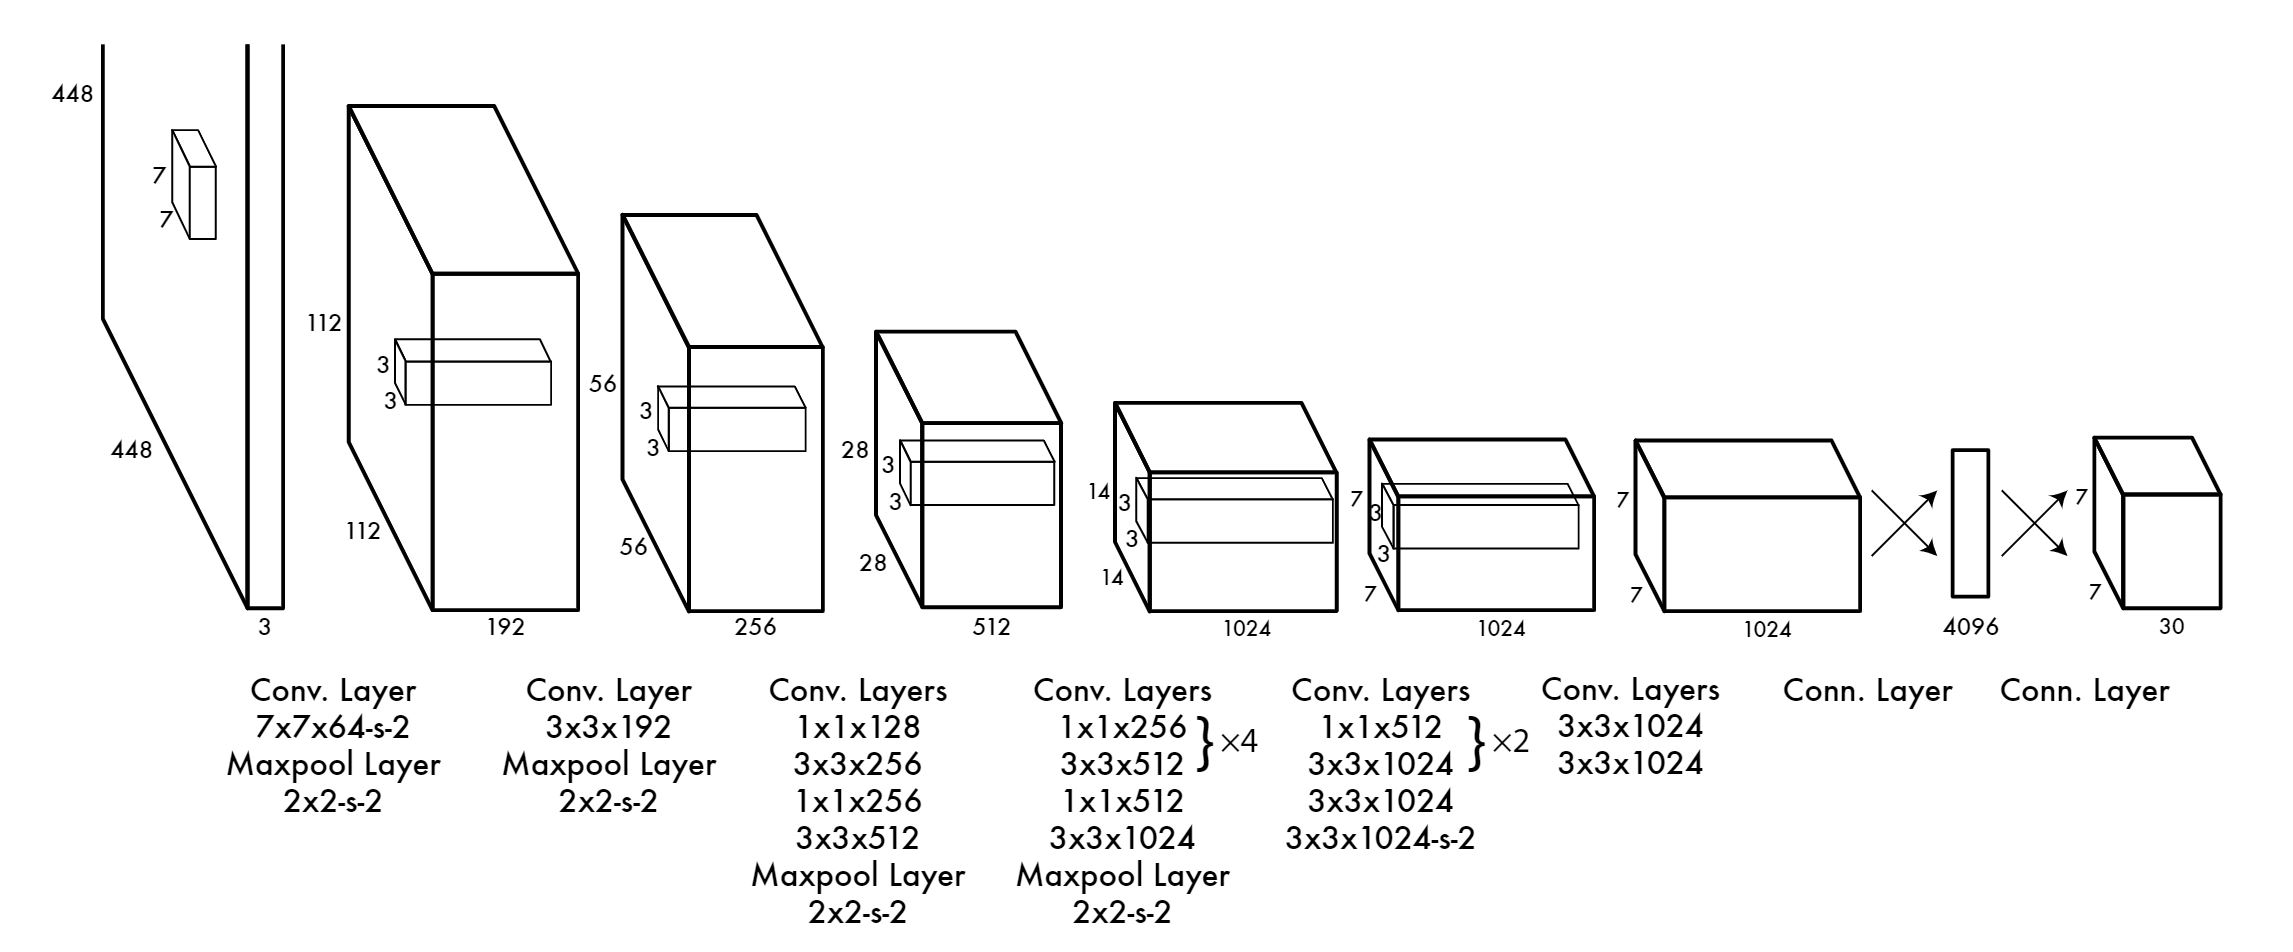

In [47]:
Display("./models/YOLO.jpg")

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D as Pool2D
from tensorflow.keras.layers import BatchNormalization as BatchNorm


def ConvBlock(x, block_num, n_filters=64, repeat=1, **kwargs):
    """ Add one 1x1 convolutional layer followed by one 3x3 layer.
    Args:
    n_filters: number of channels to output in 1x1 layer, doubled for 3x3 layer
    repeat:    times to repeat this process

    Returns: output values processed by the 1x1 + 3x3 block
    """
    z = x
    for i in range(repeat):
        b = block_num + i
        z = Conv2D(name=f'block_{b}_conv_1x1', kernel_size=1, filters=n_filters,     **kwargs)(z)
        z = Conv2D(name=f'block_{b}_conv_3x3', kernel_size=3, filters=n_filters * 2, **kwargs)(z)
        
    return z


def FeatureExtractor(input_shape=(448, 448, 3), show_summary=False):

    kwargs = dict(
        padding='same',
        activation=tf.keras.layers.LeakyReLU(alpha=0.1),
        kernel_initializer='he_normal'
    )

    x = Input(shape=input_shape, name='input')

    # 24 convolutional layers for feature extraction
    z = Conv2D(name='conv_1_7x7', kernel_size=7, strides=2, filters=64,  **kwargs)(x)
    z = BatchNorm(name='BN1')(z)
    z = Pool2D(name='pool_1_2x2', pool_size=2,   strides=2)(z)

    z = Conv2D(name='conv_2_3x3', kernel_size=3, strides=1, filters=192, **kwargs)(z)
    z = BatchNorm(name='BN2')(z)
    z = Pool2D(name='pool_2_2x2', pool_size=2,   strides=2)(z)

    z = ConvBlock(z, block_num=1, n_filters=128, **kwargs)
    z = ConvBlock(z, block_num=2, n_filters=256, **kwargs)
    z = BatchNorm(name='BN3')(z)
    z = Pool2D(name='pool_3_2x2', pool_size=2,   strides=2)(z)

    z = ConvBlock(z, block_num=3, n_filters=256, repeat=4, **kwargs)
    z = ConvBlock(z, block_num=7, n_filters=512, **kwargs)
    z = BatchNorm(name='BN4')(z)
    z = Pool2D(name='pool_4_2x2', pool_size=2,   strides=2)(z)

    z = ConvBlock(z, block_num=8, n_filters=512, repeat=2, **kwargs)
    z = BatchNorm(name='BN5')(z)
    
    model = Model(inputs=x, outputs=z, name='Extractor')

    if show_summary:
        display(model.summary())

    return model

feature_extractor = FeatureExtractor(show_summary=True)

Model: "Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 448, 448, 3)]     0         
                                                                 
 conv_1_7x7 (Conv2D)         (None, 224, 224, 64)      9472      
                                                                 
 BN1 (BatchNormalization)    (None, 224, 224, 64)      256       
                                                                 
 pool_1_2x2 (MaxPooling2D)   (None, 112, 112, 64)      0         
                                                                 
 conv_2_3x3 (Conv2D)         (None, 112, 112, 192)     110784    
                                                                 
 BN2 (BatchNormalization)    (None, 112, 112, 192)     768       
                                                                 
 pool_2_2x2 (MaxPooling2D)   (None, 56, 56, 192)       0 

None

In [49]:
conv_layer_names = [layer.name for layer in feature_extractor.layers if 'conv' in layer.name]
len(conv_layer_names)

20

---
## Pretraining for Image Classification

The image classifier simply adds a average pooling followed by fully connected layer of 20 units after the feature extractor. 

In [50]:
from tensorflow.keras.layers import GlobalAveragePooling2D as GAP2D
from tensorflow.keras.layers import Dense


def ImageClassifier(base_layers, input_shape=(224, 224, 3), n_classes=N_CLASSES, show_summary=False):

    x = Input(shape=input_shape, name='input')

    z = base_layers(input_shape=input_shape)(x)

    z = GAP2D(name='.')(z)
    z = Dense(name='output', units=n_classes, activation='softmax')(z)
    
    model = Model(inputs=x, outputs=z, name='Classifer')

    if show_summary:
        display(model.summary())

    return model


image_classifier = ImageClassifier(FeatureExtractor, show_summary=True)

Model: "Classifer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 Extractor (Functional)      (None, 7, 7, 1024)        22414400  
                                                                 
 . (GlobalAveragePooling2D)  (None, 1024)              0         
                                                                 
 output (Dense)              (None, 20)                20500     
                                                                 
Total params: 22,434,900
Trainable params: 22,429,268
Non-trainable params: 5,632
_________________________________________________________________


None

#### Set up Colab Environment

In [51]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Not connected to a GPU')
# else:
#     print(gpu_info)

In [52]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [53]:
# %cd '/content/drive/MyDrive/ADL/ObjectDetection'
# !dir

#### Pretrain Image Classifier

In [54]:
y_true = tf.convert_to_tensor([[6]], dtype='float32')
y_pred = tf.convert_to_tensor([[0., .1, 0., 0., .2, .3, .4, 0.]], dtype='float32')

print(tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred))
print(tf.metrics.SparseTopKCategoricalAccuracy(k=1)(y_true, y_pred))

tf.Tensor(0.9162911, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)


In [67]:
%%time
import os
import pickle

model_name = "image_classifier"
model_file = f"./models/{model_name}_weights.tf"
score_file = f"./models/{model_name}_history.pkl"

cls_model = ImageClassifier(base_layers=FeatureExtractor)

cls_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(name='loss'),
    metrics=tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top5'),
)

print(f"\nLoading model weights for {model_name}...")
try:
    cls_model.load_weights(model_file)
    print("Model weights successfully loaded!")
except Exception as e:
    print("Model weights not loaded!")
    pass


# use pre-trained model if available
if os.path.exists(score_file):
    print(f"\nLoading model history for {model_name}...")
    with open(score_file, 'rb') as pickle_file:
        cls_history = pickle.load(pickle_file)

# train from scratch if not available
else:
    print(f"\nTraining model {model_name}...")
    cls_history = cls_model.fit(
        cls_train,
        batch_size=BATCH_SIZE,
        epochs=100,
        verbose=1,
        validation_data=cls_valid,
        workers=200,
        use_multiprocessing=True,
    )

    print(f"\nSaving model weights for {model_name}...")
    cls_model.save_weights(model_file)

    print(f"\nSaving model history for {model_name}...")
    with open(score_file, 'wb') as pickle_file:
        pickle.dump(cls_history.history, pickle_file)



Loading model weights for image_classifier...
Model weights successfully loaded!

Loading model history for image_classifier...
Wall time: 696 ms


#### Training and Validation Performance

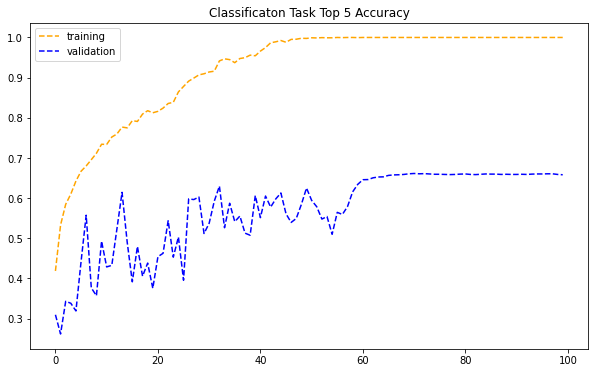

In [68]:
plt.figure(figsize=(10,6))

_ = plt.plot(cls_history['top5'], color='orange', linestyle='--', label='training')
_ = plt.plot(cls_history['val_top5'], color='blue', linestyle='--', label='validation')

plt.title('Classificaton Task Top 5 Accuracy')
plt.legend()
plt.show()

#### Evaluation Performance

In [69]:
%%time

print(f"\nEvaluating test accuracy of {model_name}...")
cls_model.evaluate(cls_test)


Evaluating test accuracy of image_classifier...
78/78 [==============================] - 116s 1s/step - loss: 5.6728 - top5: 0.6700
Wall time: 1min 56s


[5.672844886779785, 0.6700323224067688]

---
## Training for Object Detection

The object detector adds additional 4 convolutional layers and 2 fully connected layers to the previous 20 convolutional layers, with the output shape matching the `7x7x30` training targets. During training, we need to convert the x, y, w, h to box corner coordinates for IoU calculation.

In [58]:
[layer.name for layer in cls_model.layers]

['input', 'Extractor', '.', 'output']

In [59]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization as BatchNorm


def ObjectDetector(base_layers, input_shape=(448, 448, 3), show_summary=False):

    kwargs = dict(
        padding='same',
        activation=tf.keras.layers.LeakyReLU(alpha=0.1),
        # activation='relu',
        kernel_initializer='he_normal'
    )

    x = Input(shape=input_shape, name='input')

    z = base_layers(input_shape=input_shape)(x)

    z = Conv2D(name='neck_conv_1_3x3', kernel_size=3, strides=1, filters=1024, **kwargs)(z)
    z = Conv2D(name='neck_conv_2_3x3', kernel_size=3, strides=2, filters=1024, **kwargs)(z)
    z = Conv2D(name='neck_conv_3_3x3', kernel_size=3, strides=1, filters=1024, **kwargs)(z)
    z = Conv2D(name='neck_conv_4_3x3', kernel_size=3, strides=1, filters=1024, **kwargs)(z)
    z = BatchNorm(name='BN1')(z)

    z = Dense(name='affine', units=4096, activation=tf.keras.layers.LeakyReLU(alpha=0.1))(z)
    z = Dropout(name='dropout', rate=0.5)(z)
    z = Dense(name='output', units=30, activation='linear')(z)

    model = Model(inputs=x, outputs=z, name='Detector')

    if show_summary:
        display(model.summary())

    return model

image_classifier = ObjectDetector(base_layers=FeatureExtractor, show_summary=True)

Model: "Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 448, 448, 3)]     0         
                                                                 
 Extractor (Functional)      (None, 14, 14, 1024)      22414400  
                                                                 
 neck_conv_1_3x3 (Conv2D)    (None, 14, 14, 1024)      9438208   
                                                                 
 neck_conv_2_3x3 (Conv2D)    (None, 7, 7, 1024)        9438208   
                                                                 
 neck_conv_3_3x3 (Conv2D)    (None, 7, 7, 1024)        9438208   
                                                                 
 neck_conv_4_3x3 (Conv2D)    (None, 7, 7, 1024)        9438208   
                                                                 
 BN1 (BatchNormalization)    (None, 7, 7, 1024)        409

None

#### Converting Bounding Box Coordinates for IoU Calculation

In [60]:
def slice_target_vector(target_vec, n_boxes=2):

    _, S1, S2, _ = target_vec.shape 

    coords = tf.reshape(tf.slice(
            target_vec, [0, 0, 0, 0], [-1, -1, -1, 10]), shape=(-1, S1, S2, n_boxes, 5))
    c = tf.slice(coords, [0, 0, 0, 0, 0], [-1, -1, -1, -1, 1])    # (64, 7, 7, 2, 1)
    b = tf.slice(coords, [0, 0, 0, 0, 1], [-1, -1, -1, -1, -1])   # (64, 7, 7, 2, 4)
    p = tf.slice(target_vec, [0, 0, 0, 10], [-1, -1, -1, -1])

    return b, c, p


s = list(range(5)) * 2 + list(range(20))
t = tf.expand_dims(tf.expand_dims(tf.expand_dims(tf.convert_to_tensor(s), axis=0), axis=0), axis=0)
print(t)

slice_target_vector(t)

tf.Tensor(
[[[[ 0  1  2  3  4  0  1  2  3  4  0  1  2  3  4  5  6  7  8  9 10 11
    12 13 14 15 16 17 18 19]]]], shape=(1, 1, 1, 30), dtype=int32)


(<tf.Tensor: shape=(1, 1, 1, 2, 4), dtype=int32, numpy=
 array([[[[[1, 2, 3, 4],
           [1, 2, 3, 4]]]]])>,
 <tf.Tensor: shape=(1, 1, 1, 2, 1), dtype=int32, numpy=
 array([[[[[0],
           [0]]]]])>,
 <tf.Tensor: shape=(1, 1, 1, 20), dtype=int32, numpy=
 array([[[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
           15, 16, 17, 18, 19]]]])>)

In [61]:
def get_bbox_coordinates(bbox_batch):
    """ x, y, sqrt(w), sqrt(h) -> y2, x1, y2, x2
        (_, 7, 7, 2, 4) -> (-1, 4)
    """
    _, S1, S2, _, _ = bbox_batch.shape

    x = bbox_batch[:, :, :, :, 0]           # (_, 7, 7, 2, 4)
    y = bbox_batch[:, :, :, :, 1]
    w = bbox_batch[:, :, :, :, 2] ** 2
    h = bbox_batch[:, :, :, :, 3] ** 2

    # convert x, y to image scope
    x_bins = tf.cast(tf.linspace(0, 1, S1+1), tf.float32)
    x_bins = tf.transpose(tf.broadcast_to(x_bins[:-1], [S2, S1]))
    x_bins = tf.expand_dims(x_bins, axis=-1)
    x_step = 1 / S1
    x = x * x_step + x_bins
    
    y_bins = tf.cast(tf.linspace(0, 1, S2+1), tf.float32)
    y_bins = tf.broadcast_to(y_bins[:-1], [S1, S2])
    y_bins = tf.expand_dims(y_bins, axis=-1)
    y_step = 1 / S2
    y = y * y_step + y_bins

    x = tf.reshape(x, (-1, ))
    y = tf.reshape(y, (-1, ))
    w = tf.reshape(w, (-1, ))
    h = tf.reshape(h, (-1, ))

    x1 = tf.clip_by_value(x - w / 2, 0, 1)
    x2 = tf.clip_by_value(x + w / 2, 0, 1)
    y1 = tf.clip_by_value(y - h / 2, 0, 1)
    y2 = tf.clip_by_value(y + h / 2, 0, 1)
    
    return tf.stack([y1, x1, y2, x2], axis=-1)


def calculate_pred_iou(bbox_true, bbox_pred):
    """ (_, 4) -> (_, 1) """

    yt1 = bbox_true[: , 0]    # (_, )
    xt1 = bbox_true[: , 1]
    yt2 = bbox_true[: , 2]
    xt2 = bbox_true[: , 3]

    yp1 = bbox_pred[: , 0]    # (_, )
    xp1 = bbox_pred[: , 1]
    yp2 = bbox_pred[: , 2]
    xp2 = bbox_pred[: , 3]
    
    wt = xt2 - xt1
    ht = yt2 - yt1
    wp = xp2 - xp1
    hp = yp2 - yp1

    area_true = wt * ht       # (_, )
    area_pred = wp * hp  

    # get intersection coordinates
    x1 = tf.maximum(xp1, xt1)
    y1 = tf.maximum(yp1, yt1)
    x2 = tf.minimum(xp2, xt2)
    y2 = tf.minimum(yp2, yt2)
    
    w_inter = tf.maximum(0., x2 - x1)
    h_inter = tf.maximum(0., y2 - y1)

    area_inter = w_inter * h_inter
    area_union = area_pred + area_true - area_inter
    iou = area_inter / area_union
    return iou                # (_, )


def get_true_positive(b_true, b_pred, thresh=0.3):
    """ (_, 7, 7, 2, 4) -> (_ x7x7x2, ) """

    bbox_true = get_bbox_coordinates(b_true)        # (64x7x7x2, 4)
    bbox_pred = get_bbox_coordinates(b_pred)

    iou = calculate_pred_iou(bbox_true, bbox_pred)       # (64x7x7x2, )
    true_positive = tf.cast(tf.greater(iou, thresh), tf.float32)
    
    return true_positive


true = tf.ones((64, 7, 7, 2, 4))
pred = tf.ones((64, 7, 7, 2, 4))

get_true_positive(true, pred)

<tf.Tensor: shape=(6272,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

#### Customized Training Step

In [62]:
class YoloObjectDetector(tf.keras.Model):

    def __init__(self, model, backbone):
        super().__init__()
        self.model = model
        self.backbone = backbone

    def build(self, input_shape):
        super().build(input_shape)

    def compile(
        self,
        optimizer=tf.optimizers.Adam(learning_rate=0.0001),
        metrics=tf.keras.metrics.Precision(thresholds=0.5, name='precision'),
        coordinate_weight = 5,
        regularize_weight = 0.5,
        n_boxes = 2    # B
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.coordinate_weight = coordinate_weight
        self.regularize_weight = regularize_weight
        self.n_boxes = n_boxes
       # load weights for the 20 conv layers
        print("Loading pretrained weights for feature extractor...")
        pretrained_weights = self.backbone.get_layer('Extractor').get_weights()
        self.model.get_layer('Extractor').set_weights(pretrained_weights)
        print("Successfully loaded pretrained feature extractor weights!")
        

    @tf.function
    def train_step(self, data):

        inputs, y_true = data      # y_true: (_, 7, 7, 30)
        b_true, c_true, p_true = slice_target_vector(y_true, self.n_boxes)
        # b_true: (_, 7, 7, 2, 4) - x, y, sqrt(w), sqrt(h)
        # c_true: (_, 7, 7, 2, 1) - conf
        # p_true: (_, 7, 7, 20)   - class probabilities

        with tf.GradientTape() as tape:

            y_pred = tf.clip_by_value(self.model(inputs, training=True), 0, 1)
            b_pred, c_pred, p_pred = slice_target_vector(y_pred, self.n_boxes)
            
            true_pos = get_true_positive(b_true, b_pred)      # (_x7x7x2, )
            bbox_pos = tf.reshape(c_pred, (-1, ))

            coordinate_loss = tf.reduce_sum(
                tf.math.squared_difference(b_true, b_pred) * c_true
            )
            confidence_loss = tf.reduce_sum(
                tf.math.squared_difference(c_true, c_pred) * c_true
            )
            regularize_loss = tf.reduce_sum(
                tf.math.squared_difference(c_true, c_pred) * (1 - c_true)
            )
            prediction_loss = tf.reduce_sum(
                tf.math.squared_difference(p_true, p_pred) * tf.reduce_max(c_true, axis=-2)
            )

            total_loss = tf.reduce_sum([
                coordinate_loss * self.coordinate_weight, 
                confidence_loss,
                regularize_loss * self.regularize_weight,
                prediction_loss
            ])
  
        trainable = self.model.trainable_variables
        gradients = tape.gradient(total_loss, trainable)

        self.optimizer.apply_gradients(
            (grad, vars) for (grad, vars) in zip(gradients, trainable)
        )

        # (_, 7, 7, 2)
        self.compiled_metrics.update_state(true_pos, bbox_pos)

        results = {m.name: m.result() for m in self.metrics}
        results.update(dict(total_loss=total_loss))

        return results

    def call(self, inputs, *args, **kwargs):
        return tf.clip_by_value(self.model(inputs), 0, 1)


In [70]:
%%time

model_name = "object_detector"
model_file = f"./models/{model_name}_weights.tf"
score_file = f"./models/{model_name}_history.pkl"

det_model = YoloObjectDetector(
    model=ObjectDetector(base_layers=FeatureExtractor),
    backbone=cls_model
)

det_model.compile()

print(f"\nLoading model weights for {model_name}...")
try:
    det_model.load_weights(model_file)
    print("Model weights successfully loaded!")
except Exception as e:
    print("Model weights not loaded!")
    pass


# use pre-trained model if available
if os.path.exists(score_file):
    print(f"\nLoading model history for {model_name}...")
    with open(score_file, 'rb') as pickle_file:
        det_history = pickle.load(pickle_file)

# train from scratch if not available
else:
    det_history = det_model.fit(
        det_train,
        batch_size=BATCH_SIZE,
        epochs=1000,
        verbose=1,
        validation_data=det_valid,
        workers=200,
        use_multiprocessing=True,
    )

    print(f"\nSaving model weights for {model_name}...")
    det_model.save_weights(model_file)

    print(f"\nSaving model history for {model_name}...")
    with open(score_file, 'wb') as pickle_file:
        pickle.dump(det_history.history, pickle_file)


Loading pretrained weights for feature extractor...
Successfully loaded pretrained feature extractor weights!

Loading model weights for object_detector...
Model weights successfully loaded!

Loading model history for object_detector...
Wall time: 1.88 s


#### Training and Validation Performance

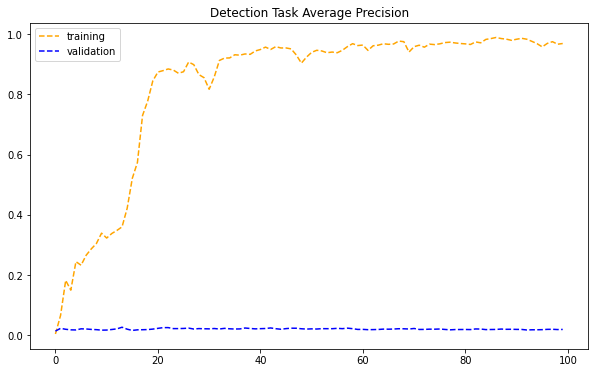

In [71]:
plt.figure(figsize=(10,6))

_ = plt.plot(det_history['precision'], color='orange', linestyle='--', label='training')
_ = plt.plot(det_history['val_precision'], color='blue', linestyle='--', label='validation')

plt.title('Detection Task Average Precision')
plt.legend()
plt.show()

#### Evaluation Performance

In [72]:
print(f"\nEvaluating test accuracy of {model_name}...")
det_model.evaluate(det_test)


Evaluating test accuracy of object_detector...
78/78 [==============================] - 508s 7s/step - loss: 0.0000e+00 - precision: 0.0124


[0.0, 0.012403207831084728]

---
## Inference Time

Let's take a look at some predictions.

#### Sample Test Data

In [73]:
for x, y in det_test.take(1):
    quick_test = tf.data.Dataset.from_tensor_slices((x[:4], y[:4])).batch(8)
    break

In [74]:
for x, y in quick_test.as_numpy_iterator():
    x_test = x
    y_test = y

print(x_test.shape, y_test.shape)

(4, 448, 448, 3) (4, 7, 7, 30)


In [75]:
predictions = det_model.predict(quick_test)
predictions.shape

(4, 7, 7, 30)

In [76]:
predictions[0][0][0].round(2)

array([0.13, 0.86, 0.72, 0.54, 0.65, 0.  , 0.57, 0.44, 0.65, 0.75, 0.  ,
       0.  , 0.  , 0.  , 0.09, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.16, 0.  , 0.  , 0.  , 0.  , 0.  ], dtype=float32)

#### Recover Bouding Box Coordinates

At inference time, the model outputs bounding box coordinates in previously explained normalized forms. Again, we need to convert them back to corner coordinates in order to visualize the bounding boxes. 

In [77]:
b_true, c_true, p_true = slice_target_vector(y_test)
b_pred, c_pred, p_pred = slice_target_vector(predictions)
b_pred.shape, c_pred.shape, p_pred.shape

(TensorShape([4, 7, 7, 2, 4]),
 TensorShape([4, 7, 7, 2, 1]),
 TensorShape([4, 7, 7, 20]))

In [117]:
idx = 1

img = x_test[idx]
img = np.clip(img * 255, 0, 255).astype(np.uint8)

bbox_true = b_true[idx]
bbox_pred = b_pred[idx]
conf_pred = c_pred[idx]
prob_pred = p_pred[idx]

# convert to y1, x1, y2, x2 coordinates
bbox_true = get_bbox_coordinates(tf.expand_dims(bbox_true, axis=0)).numpy()
bbox_pred = get_bbox_coordinates(tf.expand_dims(bbox_pred, axis=0)).numpy()
print(bbox_pred.shape)

(98, 4)


#### Confidence and Probability

$$ \text{Pr(Class}_i\text{|Object)} * \text{Pr(Object)} * \text{IoU}^\text{truth}_\text{pred} 
= \text{Pr(Class}_i\text{)} * \text{IoU}^\text{truth}_\text{pred} $$

In [118]:
conf = tf.reshape(conf_pred, (-1, )).numpy()
conf.shape

(98,)

#### Get Class Labels

In [119]:
# find class labels
labels_pred = tf.reshape(tf.repeat(tf.argmax(prob_pred, axis=-1), repeats=2, axis=-1), (-1, )).numpy()
labels_pred = [class_names[i] for i in labels_pred]
len(labels_pred)

98

In [120]:
help(draw_bboxes)

Help on function draw_bboxes in module __main__:

draw_bboxes(img, bboxes, labels, scores=None, colors=None)



#### Draw Bounding Boxes

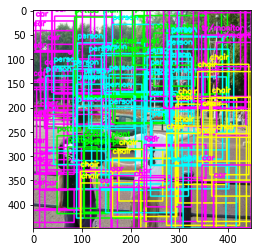

In [121]:
boxed_image = draw_bboxes(img, bbox_pred, labels_pred)
_ = plt.imshow(boxed_image)

#### Non-Maximal Suppresion

As shown above, each predictin will produce 7x7x2 = 49 anchor boxes for object detection as planned. We can implement non-max-suppresion to keep only the ones with higher confidence. This is usually done by a threshold. Since we don't have any perfect example with really high confidence, we can simply slice the highest ones. 

In [122]:
# top_idx = conf[conf >= .9]
top_idx = np.argsort(conf)[:5]  # top 5
top_idx

array([ 0, 70, 69, 68, 67], dtype=int64)

In [123]:
top_bbox = bbox_pred[top_idx]
top_bbox

array([[0.04981089, 0.01018827, 0.18550664, 0.1856719 ],
       [0.        , 0.6598888 , 0.27181232, 0.95180005],
       [0.76851285, 0.48494208, 1.        , 0.78582036],
       [0.7820894 , 0.4612195 , 1.        , 0.82513386],
       [0.6223476 , 0.51940775, 0.9025984 , 0.7264943 ]], dtype=float32)

In [124]:
top_labels = np.array(labels_pred)[top_idx]
top_labels

array(['car', 'car', 'car', 'car', 'car'], dtype='<U12')

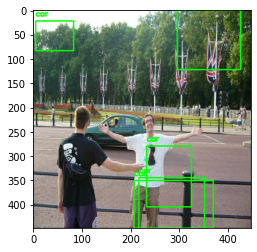

In [125]:
det_image = draw_bboxes(img, top_bbox, top_labels)
_ = plt.imshow(det_image)

Yay, we found something!